In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, gc, gzip, pickle, json
from datetime import datetime

from tensorflow.keras.backend import clear_session
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
import sys
sys.path.append('../') #to see the utils folder
from utils.STResNet import Classifier as STResNet

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

#set a nice seaborn style
import seaborn as sns
sns.set_style("darkgrid")


2024-01-18 13:59:04.715978: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 13:59:04.716004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 13:59:04.716731: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 13:59:04.720825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 13:59:05.309902: W tensorflow/compiler/tf2

In [2]:
#prinf libraries versions
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)
print('tensorflow version: ', tf.__version__)
#python 3.9.15
import sklearn
print('sklearn version: ', sklearn.__version__)


numpy version:  1.24.4
pandas version:  1.4.4
tensorflow version:  2.15.0
sklearn version:  1.0.2


In [3]:
# Create temp notebook folder if it does not exist
TEMP_FOLDER = 'temp/7_end_to_end_train_eval'
if(not os.path.exists(TEMP_FOLDER)):
    os.mkdir(TEMP_FOLDER)

In [4]:
#generate LSTM model with 2 lstm layers using keras functional API
def generate_LSTM (input_shape, output_shape, num_LSTM_layers=2, num_units=64, dropout=0.2, recurrent_dropout=0.2):
    clear_session()
    inputs = tf.keras.layers.Input(shape=input_shape)
    #add 1d batch normalization

    x = inputs
    for i in range(num_LSTM_layers):
        x = tf.keras.layers.LSTM(num_units, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)(x)
    x = tf.keras.layers.LSTM(num_units, dropout=dropout, recurrent_dropout=recurrent_dropout)(x)
    x = tf.keras.layers.Dense(num_units, activation='relu')(x)
    outputs = tf.keras.layers.Dense(output_shape, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#generate Convolutional model with 3 CNN and one fully conencted using keras functional API
def generate_CNN (input_shape, output_shape, num_CNN_layers=3, num_units=64, dropout=0.2):
    clear_session()
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    for i in range(num_CNN_layers):
        x = tf.keras.layers.Conv1D(filters=num_units, kernel_size=3, padding='same', activation='relu')(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(num_units, activation='relu')(x)
    outputs = tf.keras.layers.Dense(output_shape, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#generate ConvLSTM mode with 3 CNN layers and 1 LSTM layers using keras functional API
def generate_ConvLSTM (input_shape, output_shape, num_CNN_layers=3, num_units=64, dropout=0.2, recurrent_dropout=0.2):
    clear_session()
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    for i in range(num_CNN_layers):
        x = tf.keras.layers.Conv1D(filters=num_units, kernel_size=3, padding='same', activation='relu')(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.LSTM(num_units, dropout=dropout, recurrent_dropout=recurrent_dropout)(x)
    x = tf.keras.layers.Dense(num_units, activation='relu')(x)
    outputs = tf.keras.layers.Dense(output_shape, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



#generate transofrmer model with 3 layers for a multi channel input using keras functional API
def generate_transformer (input_shape, output_shape, num_heads=2, num_transformer_blocks=2, num_units=16, dropout=0.2):
    clear_session()
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    for i in range(num_transformer_blocks):
        x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=num_units, dropout=dropout)(x, x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout)(x)
        x = tf.keras.layers.Dense(num_units, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(output_shape, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



#generate STResnet model
def generate_STResnet(signal_size,num_channels,sampling_rate,num_classes):
    clear_session()

    signal_sizes = [signal_size]*num_channels #in this case the signal size is the same for all channels, but the model aloows different sizes
    sampling_rates = [sampling_rate]*num_channels #in this case the sampling rate is the same for all channels, but the model aloows different sizes
    fft_win_len_factor = 30 #len of fft windows in seconds
    fft_win_length = []
    hop_length = [] 

    for i in range(len(signal_sizes)):
            fft_win_length.append(sampling_rates[i]*fft_win_len_factor)
            hop_length.append(int(fft_win_length[i]//2))

    model_config = []
    with open("../utils/STResNet_config.json") as json_file: 
            model_config = json.load(json_file)
            model_config['signal_size'] = signal_sizes
            model_config['num_channels'] = len(signal_sizes) 
            model_config['sampling_rate'] = sampling_rates
            
            model_config['fft_win_length'] = fft_win_length
            model_config['hop_length'] = hop_length
            model_config['max_filters'] = 32
            model_config['num_filters'] = 16
            model_config['num_res_blocks'] = 4

    STResNet_model = STResNet(model_config,num_classes,verbose = 1)
    
    return STResNet_model.model


In [5]:
SAMPLING_RATE = 10

INFO_COLUMNS = ['Participant_No', 'Condition', 'Segment','Time']
EMG_AMP_COLUMNS = ['Emg/Amplitude[RightOrbicularis]',
               'Emg/Amplitude[RightZygomaticus]',
               'Emg/Amplitude[RightFrontalis]',
               'Emg/Amplitude[CenterCorrugator]',
               'Emg/Amplitude[LeftFrontalis]',
               'Emg/Amplitude[LeftZygomaticus]',
               'Emg/Amplitude[LeftOrbicularis]']
EMG_CONTACT_COLUMNS = ['Emg/Contact[RightOrbicularis]',
               'Emg/Contact[RightZygomaticus]',
               'Emg/Contact[RightFrontalis]',
               'Emg/Contact[CenterCorrugator]',
               'Emg/Contact[LeftFrontalis]',
               'Emg/Contact[LeftZygomaticus]',
               'Emg/Contact[LeftOrbicularis]']
HR_COLUMNS = ['HeartRate/Average', 'Ppg/Raw.ppg']
IMU_COLUMNS = ['Accelerometer/Raw.x', 'Accelerometer/Raw.y', 'Accelerometer/Raw.z', 
               'Gyroscope/Raw.x', 'Gyroscope/Raw.y', 'Gyroscope/Raw.z']
EYE_COLUMNS = ['VerboseData.Right.PupilDiameterMm','VerboseData.Left.PupilDiameterMm']
BIOPAC_RR_COLUMNS = ['Biopac_RSP']
BIOPAC_GSR_COLUMNS = ['Biopac_GSR']
SENSOR_COLUMNS = EMG_AMP_COLUMNS + EMG_CONTACT_COLUMNS + HR_COLUMNS + IMU_COLUMNS + EYE_COLUMNS + BIOPAC_RR_COLUMNS + BIOPAC_GSR_COLUMNS

ALL_COLUMNS = INFO_COLUMNS + SENSOR_COLUMNS

PROCESSED_DATA_FOLDER = 'temp/6_end_to_end_preprocess_data'


#load segments and labels
#with gzip.open(os.path.join(PROCESSED_DATA_FOLDER, 'segments_all_sensor_dict.pkl.gz'), 'rb') as f:
#    segments_sensor_dict = pickle.load(f)
#with gzip.open(os.path.join(PROCESSED_DATA_FOLDER, 'segments_hr_dict.pkl.gz'), 'rb') as f:
#    segments_sensor_dict = pickle.load(f)
with gzip.open(os.path.join(PROCESSED_DATA_FOLDER, 'segments_labels_dict.pkl.gz'), 'rb') as f:
    segments_labels_dict = pickle.load(f)

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())




[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12417455444022527216
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23587782656
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9893347018206930304
physical_device_desc: "device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:02:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2024-01-18 13:59:06.340700: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 13:59:06.366686: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 13:59:06.366845: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
TF_DEVICE = "0"
def my_set_session():
    os.environ["CUDA_VISIBLE_DEVICES"] = TF_DEVICE
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True) #allocte memory as needed
        memory_growth = tf.config.experimental.get_memory_growth(gpu)
        print(f"Memory growth for GPU {gpu.name}: {memory_growth}")
    return()
    
my_set_session()

Memory growth for GPU /physical_device:GPU:0: True


2024-01-18 13:59:06.440671: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 13:59:06.440876: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 13:59:06.440979: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

()

2024-01-18 13:59:06.550118: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 13:59:06.550326: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 13:59:06.550429: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Number of parameters:  87746


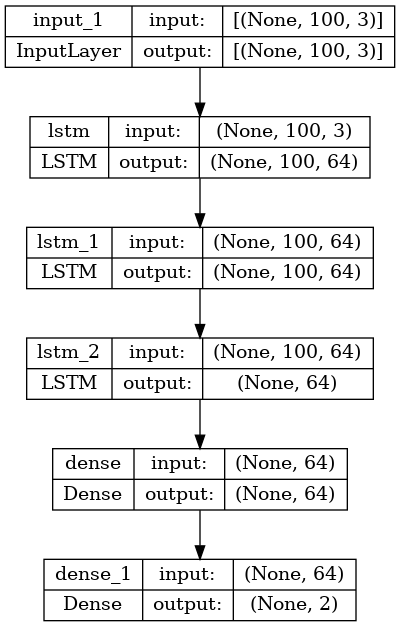

In [8]:
#plot model shapes 
model = generate_LSTM(input_shape=(100, 3), output_shape=2)
#print only model parameters
print('Number of parameters: ', model.count_params())
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)


Number of parameters:  74690


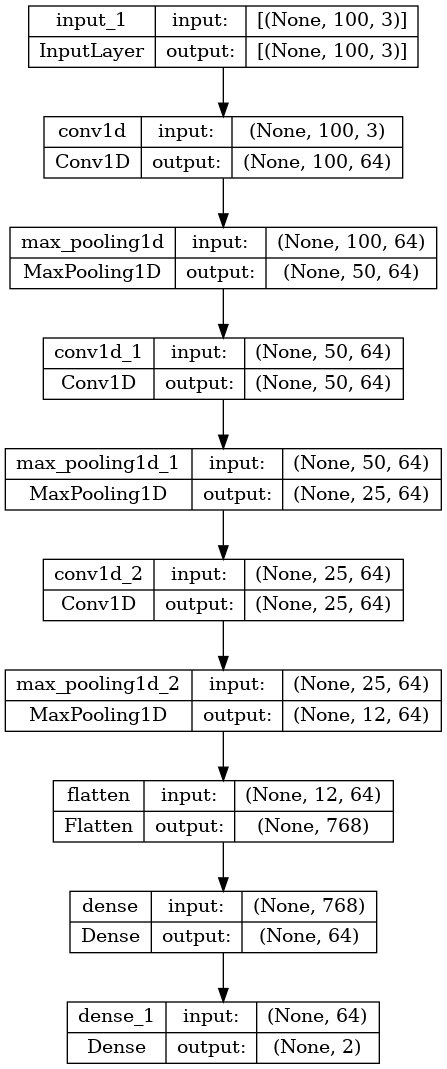

In [9]:
#plot model shapes 
model = generate_CNN(input_shape=(100, 3), output_shape=2)
print('Number of parameters: ', model.count_params())
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)


Number of parameters:  62658


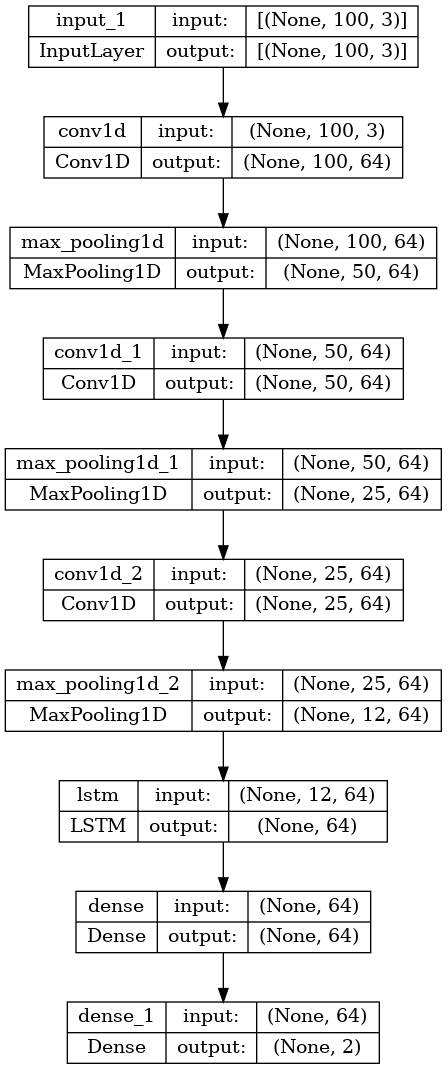

In [10]:
#plot model shapes 
model = generate_ConvLSTM(input_shape=(100, 3), output_shape=2)
print('Number of parameters: ', model.count_params())
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Number of parameters:  3217


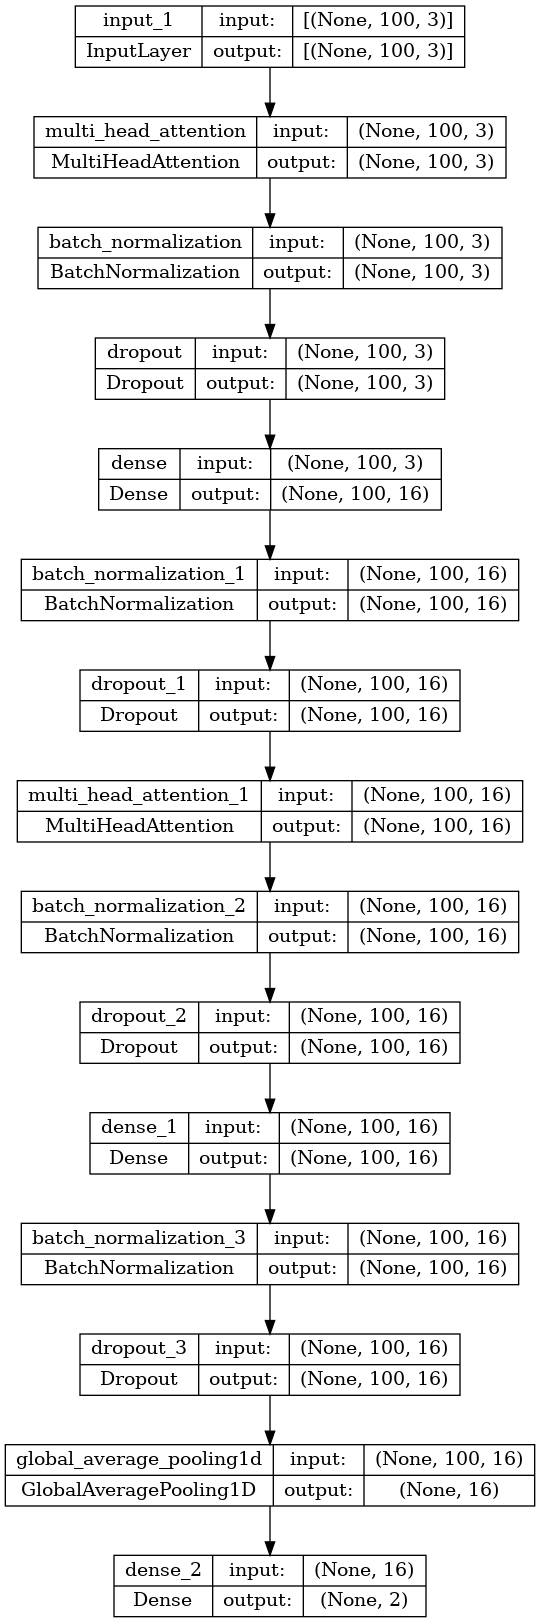

In [11]:
#plot model shapes 
model = generate_transformer(input_shape=(100, 3), output_shape=2)
print('Number of parameters: ', model.count_params())
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Number of parameters:  157630


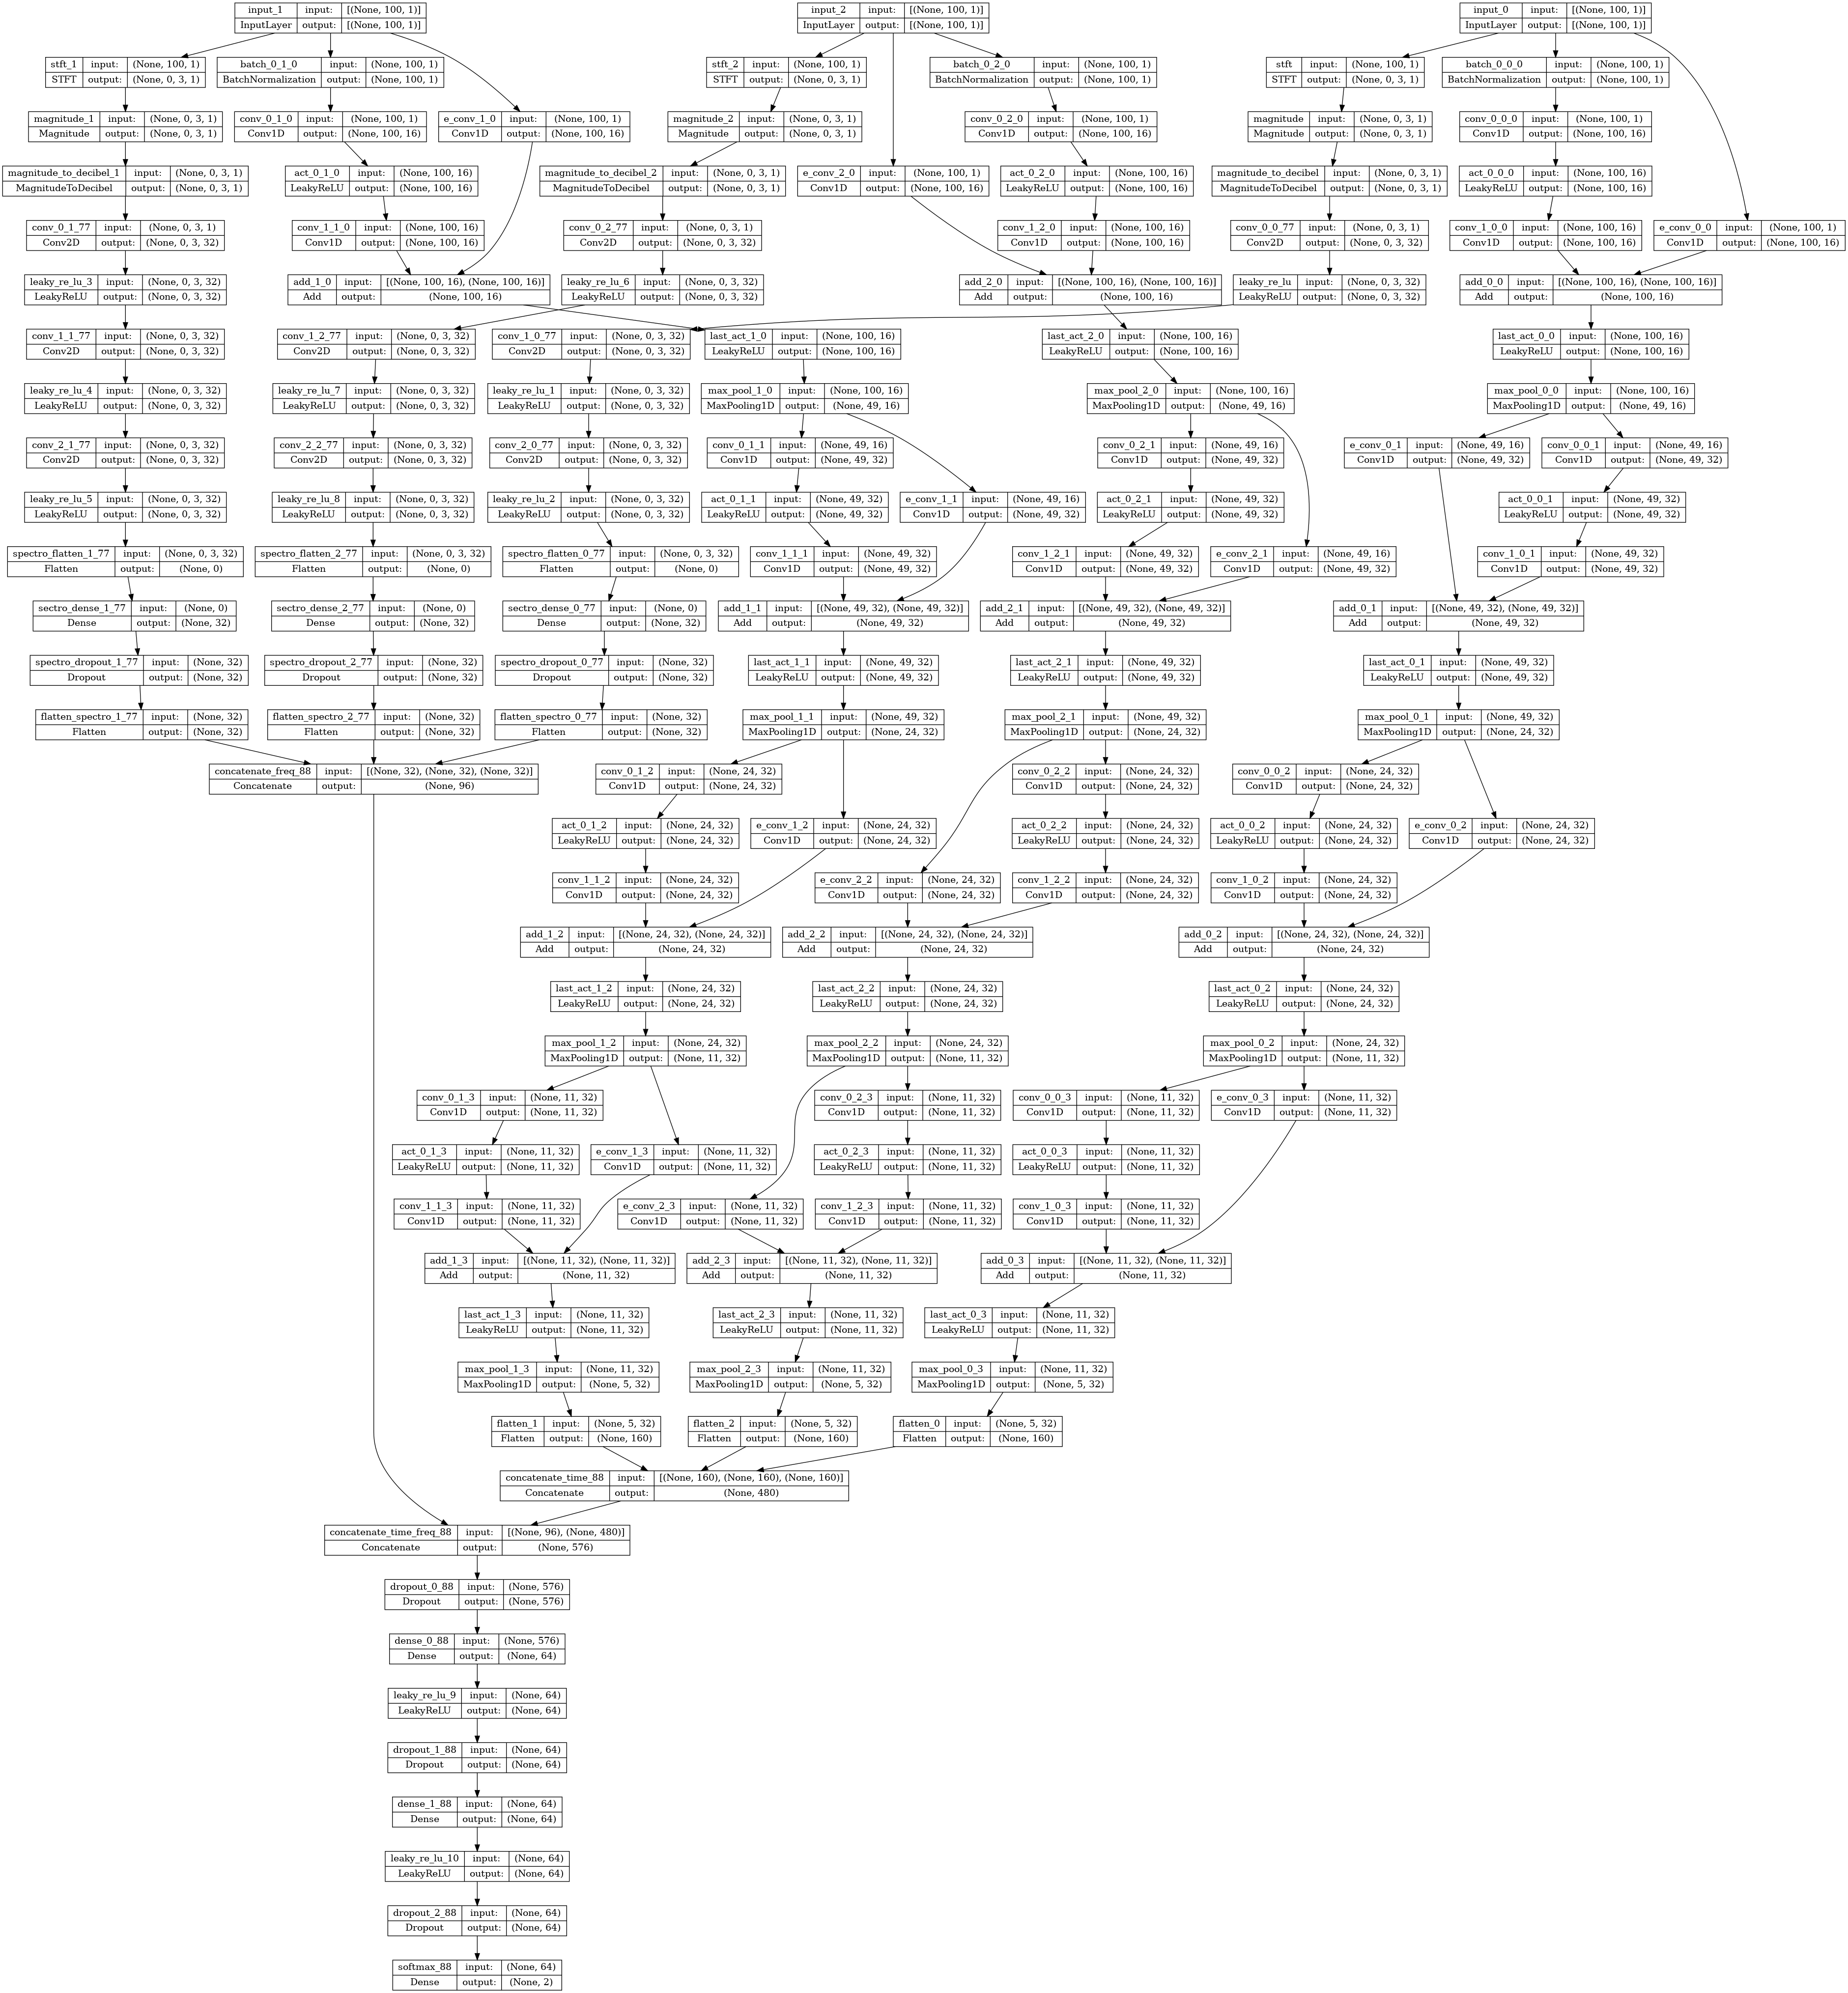

In [12]:
##plot STResNet shapes 
model = generate_STResnet(signal_size=100,num_channels=3,sampling_rate=10,num_classes=2)
print('Number of parameters: ', model.count_params())
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)



In [13]:
def train_evaluate_DL_model(X_train,y_train,
                            X_valid,y_valid,
                            X_test,y_test,
                            model_func,model_name):
    batch_size = 512
    epochs = 150
    num_classes = len(np.unique(y_train))
    output_shape = num_classes

  
    metric = 'val_accuracy' #STResNet names val_acc, others val_accuracy
    if model_name == 'STResNet':
        model = model_func(signal_size = X_train[0].shape[-1],
                           num_channels = len(X_train),
                           sampling_rate = SAMPLING_RATE,
                           num_classes=num_classes)
        metric = 'val_acc'
    else:
        input_shape = X_train.shape[1:]
        model = model_func(input_shape, output_shape)
    
  #define callbacks for model checkpointing 
    model_path = './models/'+model_name+'_model.h5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,
                                                                     monitor=metric,
                                                                        mode='max',
                                                                        verbose=0,
                                                                        save_best_only=True)

    history = model.fit(X_train, y_train, 
                             epochs=epochs, 
                             validation_data=(X_valid, y_valid),
                             batch_size=batch_size,
                                callbacks=[model_checkpoint_callback],
                             verbose=0, shuffle=True)
    #load best model
    model.load_weights(model_path)

    #evaluate model
    y_pred_onehot = model.predict(X_test,verbose=0)
    y_pred = np.argmax(y_pred_onehot, axis=1)
    y_test = np.argmax(y_test, axis=1)
    test_acc = accuracy_score(y_test, y_pred).round(2)

    #validation accuracy
    y_pred_onehot = model.predict(X_valid,verbose=0)
    y_pred = np.argmax(y_pred_onehot, axis=1)
    y_valid = np.argmax(y_valid, axis=1)
    valid_acc = accuracy_score(y_valid, y_pred).round(2)
    print(datetime.now().strftime("%H:%M:%S"), 'Test acc:',test_acc, 'Valid acc:',valid_acc)

    del model

    return test_acc,y_pred_onehot, history.history


In [14]:
def getColumnIndexRange(columnList):
    sensorIndexList = []
    for signalColumn in columnList:
        sensorIndexList.append(SENSOR_COLUMNS.index(signalColumn))
    return sensorIndexList

In [15]:
#modalities = {
#    'EMG_A': EMG_AMP_COLUMNS,
#    'EMG_C': EMG_CONTACT_COLUMNS , 
#    'HR': HR_COLUMNS,
#    'IMU': IMU_COLUMNS ,
#    'PupilSize': EYE_COLUMNS ,
#    'GSR': BIOPAC_GSR_COLUMNS ,
#    'RSP': BIOPAC_RR_COLUMNS ,
#    'ALL': SENSOR_COLUMNS 
#}

modalities = {
    'EMG_A': 'segments_emg_amp_dict.pkl.gz',
    'EMG_C': 'segments_emg_contact_dict.pkl.gz' , 
    'HR': 'segments_hr_dict.pkl.gz',
    'IMU': 'segments_imu_dict.pkl.gz' ,
    'PupilSize': 'segments_eye_dict.pkl.gz' ,
    'GSR': 'segments_gsr_dict.pkl.gz' ,
    'RSP': 'segments_rr_dict.pkl.gz' ,
    'ALL': 'segments_all_sensor_dict.pkl.gz' 
}

#functions thatinitiate models
model_functions = {'STResNet': generate_STResnet,
                   'CNN': generate_CNN, 
    'ConvLSTM': generate_ConvLSTM,
     'LSTM': generate_LSTM,
    'Transformer': generate_transformer,
    }


In [17]:
# Main ML training loop
for modality in modalities:
    if modality in ['EMG_A', 'EMG_C']:
        continue
    print('Running for: ' + modality)
    #get index of desired signal columns

    data_file = os.path.join(PROCESSED_DATA_FOLDER, modalities[modality])
    with gzip.open(data_file, 'rb') as f:
        print('Loading file: ' + data_file)
        segments_sensor_dict = pickle.load(f)

    #create 5 folds of non-overalpping user ids for person-independent 5-fold cross validation
    users = list(segments_sensor_dict.keys())
    np.random.shuffle(users)
    folds = np.array_split(users, 5)



    test_acc_dict = {}
    history_dict = {}
    users = list(segments_sensor_dict.keys())
    for model_name, model_func in model_functions.items(): 
        if model_name == 'LSTM':
            continue
        print('-------model: ', model_name)
        test_acc_arr = []
        test_predictions_arr = []
        train_history_arr = []

        for test_users in folds:
            print('test users: ', test_users)
            #split data into train and test
            X_train = []
            y_train = []
            X_valid = []
            y_valid = []
            X_test = []
            y_test = []

            validation_counter = 0
            num_validation_users = 5
            for user in users:
                if user in test_users:
                    X_test.extend(np.array(segments_sensor_dict[user])) #select only columns we want to use as input
                    y_test.extend(segments_labels_dict[user]) 
                else:
                    validation_counter += 1
                    if validation_counter <= num_validation_users: #use first n users for validations
                        X_valid.extend(np.array(segments_sensor_dict[user]))
                        y_valid.extend(segments_labels_dict[user])
                    else:
                        X_train.extend(np.array(segments_sensor_dict[user])) #select only columns we want to use as input
                        y_train.extend(segments_labels_dict[user])
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            X_valid = np.array(X_valid)
            y_valid = np.array(y_valid)
            X_test = np.array(X_test)
            y_test = np.array(y_test)

            y_train = y_train[:,0] #the whole segment has the same label, so we can just take the first one
            y_valid = y_valid[:,0] #the whole segment has the same label, so we can just take the first one
            y_test = y_test[:,0] #the whole segment has the same label, so we can just take the first one

            #one-hot encode labels
            onehot_encoder = OneHotEncoder(sparse=False)
            y_train = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
            y_valid = onehot_encoder.transform(y_valid.reshape(-1, 1))
            y_test = onehot_encoder.transform(y_test.reshape(-1, 1))

            if model_name == 'STResNet':
                X_train = X_train.transpose(2,0,1)
                X_valid = X_valid.transpose(2,0,1)
                X_test = X_test.transpose(2,0,1)

                #convert data into a list of inputs suitable for STResNet
                X_train = [x for x in X_train]
                X_valid = [x for x in X_valid]
                X_test = [x for x in X_test]

            if test_users[0] == folds[0][0]: #print only once

                print('X_train shape: ', np.array(X_train).shape)
                print('X_valid shape: ', np.array(X_valid).shape)
                print('X_test shape: ', np.array(X_test).shape)
                print('y_train shape: ', y_train.shape)
                print('y_valid shape: ', y_valid.shape)
                print('y_test shape: ', y_test.shape)
                print()

            acc, test_predictions, history = train_evaluate_DL_model(X_train,y_train,
                                                                        X_valid,y_valid,
                                                                     X_test,y_test,
                                                                     model_func,model_name=model_name)
            clear_session()
            gc.collect()
            print()

            test_acc_arr.append(acc)
            test_predictions_arr.append(test_predictions)
            train_history_arr.append(history)

            del X_train, y_train, X_test, y_test, test_predictions, history
            gc.collect()


        #save results
        test_acc_dict[model_name] = test_acc_arr
        history_dict[model_name] = train_history_arr

        #save intermediate results            
        with open(os.path.join(TEMP_FOLDER,modality + '_test_acc_dict.pkl'), 'wb') as f:
            pickle.dump(test_acc_dict, f)    
        with open(os.path.join(TEMP_FOLDER,modality + '_test_predictions_arr.pkl'), 'wb') as f:
            pickle.dump(test_predictions_arr, f)
        with open(os.path.join(TEMP_FOLDER,modality + '_history_dict.pkl'), 'wb') as f:
            pickle.dump(history_dict, f)
    

Running for: HR
Loading file: temp/6_end_to_end_preprocess_data/segments_hr_dict.pkl.gz
-------model:  STResNet
test users:  ['2_john' '49_harris_hadjiantonis' '16_james_d' '46_james_ogorman'
 '28_atul_singh' '13_hubert' '38_ryan_davies' '51_marton_nagy'
 '23_peter_h' '26_joshua_ra']
X_train shape:  (2, 14888, 300)
X_valid shape:  (2, 2440, 300)
X_test shape:  (2, 4789, 300)
y_train shape:  (14888, 2)
y_valid shape:  (2440, 2)
y_test shape:  (4789, 2)



2024-01-18 13:59:21.946342: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


14:00:28 Test acc: 0.83 Valid acc: 0.74

test users:  ['59_malcolm_easton' '27_roy_kibe' '36_rostislavs_popovs' '18_karol_k'
 '25_james_he' '15_amy' '17_paul_w' '14_corin' '37_alejandro']
14:01:38 Test acc: 0.86 Valid acc: 0.87

test users:  ['11_john_l' '19_shayaan' '20_alex_w' '29_matthew_wright' '7_aliaksei'
 '43_kacper_dworski' '34_benjamin_pomeroy' '32_emin_akbay'
 '35_prabooganesh_suria']
14:02:45 Test acc: 0.72 Valid acc: 0.77

test users:  ['62_timothy_dsouza' '55_matthew_lui' '45_bilaal_rashid'
 '52_thomas_charnock' '48_rishi_nayan' '12_alex_b' '63_reuben_moerman'
 '24_alasdair_m' '60_hamant_rana']
14:03:51 Test acc: 0.85 Valid acc: 0.78

test users:  ['54_pranav_sistla' '57_yasir_chowdhury' '33_muhhamad_aiman' '9_dan'
 '53_lewis_grout' '44_jamie_holden' '61_freddie_simpson' '22_michael_s'
 '47_haveer_dookhit']
14:04:56 Test acc: 0.79 Valid acc: 0.8

-------model:  CNN
test users:  ['2_john' '49_harris_hadjiantonis' '16_james_d' '46_james_ogorman'
 '28_atul_singh' '13_hubert' 

2024-01-18 14:04:57.455181: I external/local_xla/xla/service/service.cc:168] XLA service 0x95fc540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-18 14:04:57.455201: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-01-18 14:04:57.458566: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705583097.523532 2242614 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14:05:27 Test acc: 0.76 Valid acc: 0.7

test users:  ['59_malcolm_easton' '27_roy_kibe' '36_rostislavs_popovs' '18_karol_k'
 '25_james_he' '15_amy' '17_paul_w' '14_corin' '37_alejandro']
14:05:58 Test acc: 0.7 Valid acc: 0.77

test users:  ['11_john_l' '19_shayaan' '20_alex_w' '29_matthew_wright' '7_aliaksei'
 '43_kacper_dworski' '34_benjamin_pomeroy' '32_emin_akbay'
 '35_prabooganesh_suria']
14:06:29 Test acc: 0.67 Valid acc: 0.71

test users:  ['62_timothy_dsouza' '55_matthew_lui' '45_bilaal_rashid'
 '52_thomas_charnock' '48_rishi_nayan' '12_alex_b' '63_reuben_moerman'
 '24_alasdair_m' '60_hamant_rana']
14:06:59 Test acc: 0.81 Valid acc: 0.76

test users:  ['54_pranav_sistla' '57_yasir_chowdhury' '33_muhhamad_aiman' '9_dan'
 '53_lewis_grout' '44_jamie_holden' '61_freddie_simpson' '22_michael_s'
 '47_haveer_dookhit']
14:07:29 Test acc: 0.76 Valid acc: 0.63

-------model:  ConvLSTM
test users:  ['2_john' '49_harris_hadjiantonis' '16_james_d' '46_james_ogorman'
 '28_atul_singh' '13_hube

In [ ]:
#read intermediate results
with open('test_acc_dict.pkl', 'rb') as f:
    test_acc_dict = pickle.load(f)
with open('history_dict.pkl', 'rb') as f:
    history_dict = pickle.load(f)

In [ ]:
#make a table with results per model with average and standard deviation
results_df = pd.DataFrame()
for model_name, test_acc_arr in test_acc_dict.items():
    results_df.loc[model_name, 'Test acc mean'] = np.mean(test_acc_arr)
    results_df.loc[model_name, 'test acc std'] = np.std(test_acc_arr)
results_df = results_df.round(2)
results_df.to_csv('results_5_fold_user_independent.csv')
results_df

In [ ]:
#plt average accuracy withper epoch with
model_colors = {'CNN': 'blue', 'STResNet': 'red', 'ConvLSTM': 'green', 'LSTM': 'orange', 'Transformer': 'purple'}
plt.figure(figsize=(10,5))
plt.title('Training accuracy per epoch')
for model_name, history_arr in history_dict.items():
    model_acc_arr = []
    for history in history_arr:
        if model_name == 'STResNet':
            fold_acc = history['acc']
        else:
            fold_acc = history['accuracy']
        model_acc_arr.append(fold_acc)
    
    plt.plot(np.mean(model_acc_arr, axis=0), color=model_colors[model_name], label=model_name)
    #plot shaded confidence
    mean = np.mean(model_acc_arr, axis=0)
    std = np.std(model_acc_arr, axis=0)
    plt.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=0.2, color=model_colors[model_name])
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()


In [ ]:
#plt average accuracy withper epoch with
model_colors = {'CNN': 'blue', 'STResNet': 'red', 'ConvLSTM': 'green', 'LSTM': 'orange', 'Transformer': 'purple'}
plt.figure(figsize=(10,5))
plt.title('Validation accuracy per epoch')
for model_name, history_arr in history_dict.items():
    model_acc_arr = []
    for history in history_arr:
        if model_name == 'STResNet':
            fold_acc = history['val_acc']
        else:
            fold_acc = history['val_accuracy']
        model_acc_arr.append(fold_acc)
    
    plt.plot(np.mean(model_acc_arr, axis=0), color=model_colors[model_name], label=model_name)
    #plot shaded confidence
    mean = np.mean(model_acc_arr, axis=0)
    std = np.std(model_acc_arr, axis=0)
    plt.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=0.2, color=model_colors[model_name])
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
